In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt

np.random.seed(42)
ROOT_PATH = os.path.normpath(os.path.join(os.getcwd(), os.pardir))
ROOT_PATH

'/home/franchetto4/github/StatMatMethodsAI'

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    data = pd.read_csv("/content/drive/MyDrive/data.csv")
except:
    data = pd.read_csv(os.path.join(ROOT_PATH, "data", "data.csv"))
# Load the data

print("Shape of data {}".format(data.shape))

Shape of data (42000, 785)


In [3]:
def data_splits(X, Y, N_train):
    N = X.shape[1]

    # getting an array with indeces from 0 to N-1
    indeces = np.arange(N)
    # shuffling randomly
    np.random.shuffle(indeces)

    # get the first N_train for the train split (but now they are random)
    train_idx = indeces[:N_train]
    # the rest are for test split
    test_idx = indeces[N_train:]

    # slice the original datasets with an index array
    X_train = X[:, train_idx]  
    Y_train = Y[train_idx]
    
    X_test = X[:, test_idx]
    Y_test = Y[test_idx]

    # put in tuples the two splits
    return (X_train, Y_train), (X_test, Y_test)


def get_data_from_index(X, Y, indexes):
    
    # start from empty lists for both samples and labels
    final_X = []
    final_Y = []

    # for each chosen label
    for k in indexes:
        # find which samples have label=k
        idxs_k = (Y == k)
        # slice the samples and append them to a list
        final_X.append( X[:, idxs_k] )
        # same thing to the labels
        final_Y.append( Y[idxs_k] )

    # concatenate together all the previous iterations
    X = np.concatenate(final_X, axis=1)
    Y = np.concatenate(final_Y)

    # return the new dataset and labels
    return X, Y

In [4]:
def get_data_given_indeces_and_split(data, indeces, N_train):
    data_copied = np.array(data)
    X = data_copied[:, 1:]
    X = X.T
    Y = data_copied[:, 0]

    d, N = X.shape
    X_hat = np.concatenate((np.ones((1,N)), X), axis=0) #for logistic

    X_hat, Y = get_data_from_index(X_hat, Y, indeces)
    _, N = X_hat.shape

    if N_train > 0.90*N:
        print("N_train too big, was brouoght to 0.90*N")
        N_train = round(0.90*N)

    (X_train, Y_train), (X_test, Y_test) = data_splits(X_hat, Y, N_train) #X_hat for logistic
    
    Y_train = np.array(list(map(lambda x: 0 if x==indeces[0] else 1, Y_train)))
    Y_test = np.array(list(map(lambda x:  0 if x==indeces[0] else 1, Y_test)))
    
    return X_train, Y_train, X_test, Y_test

In [5]:
indeces = [0, 6]
N_train = 4000

X_train, Y_train, X_test, Y_test = get_data_given_indeces_and_split(data, indeces, N_train)

d, N = X_train.shape

print(N)

4000


In [6]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def model(w, x_hat):
    return sigmoid(x_hat.T @ w)

def loss_func(w, x_hat, y, model):
    return np.linalg.norm(model(w, x_hat)-y)**2/(2*len(y))

def grad_func(w, x_hat, y, model):
    func_value = model(w, x_hat)
    return x_hat @ (func_value * (1-func_value) * (func_value - y))/(len(y))

def predict(w, x, model, treshold=0.5):
    results = model(w, x)
    return np.array([1 if r>=treshold else 0 for r in results])

In [7]:
def is_fininshed(grad_f, wk, wk_1, w0, x, y, model, tolf, tolx):
    flag_rel = np.linalg.norm(grad_f(wk, x, y, model))**2 < (tolf * np.linalg.norm(grad_f(w0, x, y, model))**2)
    flag_abs = np.linalg.norm(wk-wk_1)**2 < tolx
    return flag_rel and flag_abs

In [8]:
def SGD(loss_func, grad_func, model, w0, data, batch_size, n_epochs):
    '''
    Applies SGD on a logistic regressor with MSE loss
    If batch_size is set to -1, we configure it as normal GD with stopping conditions
    '''
    alpha = 1e-5
    tolx = 1e-6
    tolf = 1e-6
    
    X, Y = data

    w = [w0]
    loss_val = []
    grads_val = []
    err_val = []

    # set up for normal GD
    if batch_size == -1:
        batch_size = len(Y)
        n_epochs = 100

    k=0
    for epoch in tqdm(range(n_epochs)):
        indeces = np.arange(len(Y))
        np.random.shuffle(indeces)
        X = X[:,indeces]
        Y = Y[indeces]

        for i in range(0, len(Y), batch_size):
            batch_X = X[:,i:i+batch_size]
            batch_Y = Y[i:i+batch_size]

            new_weights = w[-1] - alpha*grad_func(w[-1], batch_X, batch_Y, model)

            w.append(new_weights)
            k += 1

        loss_val.append(loss_func(w[-1], X, Y, model))
        grads_val.append(grad_func(w[-1], X, Y, model))
        err_val.append(np.linalg.norm(grads_val[-1])**2)

        # GD convergence check
        if batch_size == len(Y):
            if is_fininshed(grad_func, w[-1], w[-2], w[0], X, Y, model, tolf, tolx):
                break
    
    return w, loss_val, grads_val, err_val

In [9]:
w, loss_val, grads_val, err_val = SGD(loss_func, grad_func, model, np.ones(d)*1e-5, (X_train, Y_train), 512, 200)

100%|██████████| 200/200 [00:26<00:00,  7.61it/s]


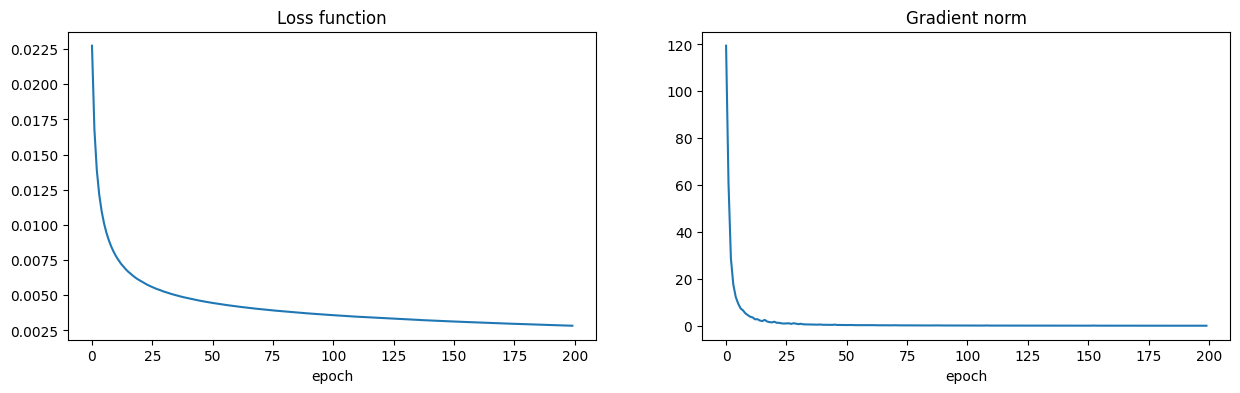

In [10]:
_, axs = plt.subplots(1, 2, figsize=(15, 4))

axs[0].plot(loss_val)
axs[0].set_title("Loss function")
axs[0].set_xlabel("epoch")

axs[1].plot(err_val)
axs[1].set_title("Gradient norm")
axs[1].set_xlabel("epoch")

plt.show()

In [11]:
accuracy = np.mean([predict(w[-1], X_test, model)==Y_test])
print("Accuracy of the logistic regression classifier: {:.2f}%".format(accuracy*100))

Accuracy of the logistic regression classifier: 98.88%


In [12]:
value_list = [
    {"digits":[0, 1], "N_train": 4000, "legend":"[0, 1] - 4000"},
    {"digits":[2, 3], "N_train": 4000, "legend":"[2, 3] - 4000"},
    {"digits":[4, 5], "N_train": 4000, "legend":"[4, 5] - 4000"},
    {"digits":[6, 7], "N_train": 4000, "legend":"[6, 7] - 4000"},
    {"digits":[8, 9], "N_train": 4000, "legend":"[8, 9] - 4000"},
]

100%|██████████| 30/30 [00:02<00:00, 11.43it/s]


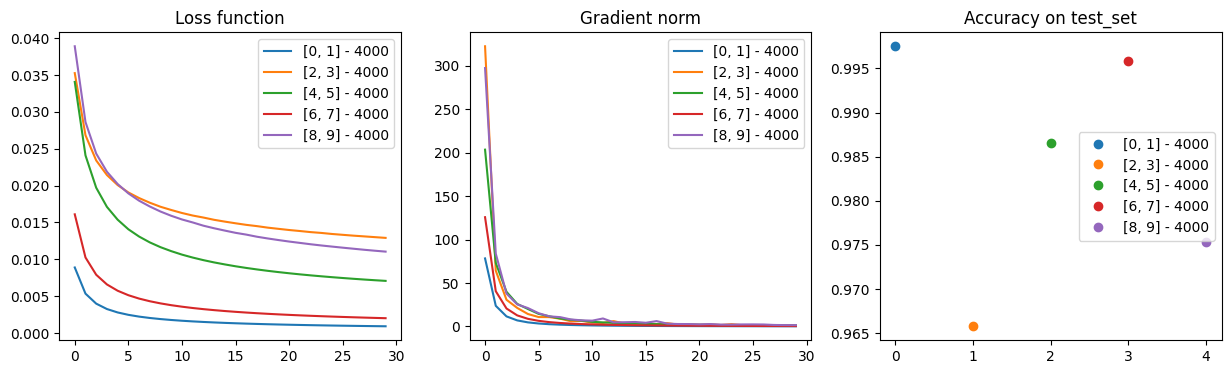

In [13]:
_, axs = plt.subplots(1, 3, figsize=(15, 4))

for i, value in enumerate(value_list):
    X_train, Y_train, X_test, Y_test = get_data_given_indeces_and_split(data, value["digits"], value["N_train"])
    w, loss_val, grads_val, err_val = SGD(loss_func, grad_func, model, np.ones(d)*1e-5, (X_train, Y_train), 512, 30)
    accuracy = np.mean([predict(w[-1], X_test, model)==Y_test])

    axs[0].plot(loss_val)
    axs[1].plot(err_val)
    axs[2].plot(i, accuracy, "o")

axs[0].set_title("Loss function")
axs[0].legend([v["legend"] for v in value_list])
axs[1].set_title("Gradient norm")
axs[1].legend([v["legend"] for v in value_list])
axs[2].set_title("Accuracy on test_set")
axs[2].legend([v["legend"] for v in value_list])

plt.show()

All accuracies are very high but some pairs of digits are more difficult to differenciate than others

In [14]:
value_list = [
    {"digits":[2, 3], "N_train": 500, "legend":"[2, 3] - 500"},
    {"digits":[2, 3], "N_train": 1000, "legend":"[2, 3] - 1000"},
    {"digits":[2, 3], "N_train": 2000, "legend":"[2, 3] - 2000"},
    {"digits":[2, 3], "N_train": 4000, "legend":"[2, 3] - 4000"},
    {"digits":[2, 3], "N_train": 6000, "legend":"[2, 3] - 6000"},
    {"digits":[2, 3], "N_train": 8000, "legend":"[2, 3] - 8000"},
]

100%|██████████| 30/30 [00:03<00:00,  7.79it/s]


N_train too big, was brouoght to 0.90*N


100%|██████████| 30/30 [00:05<00:00,  5.53it/s]


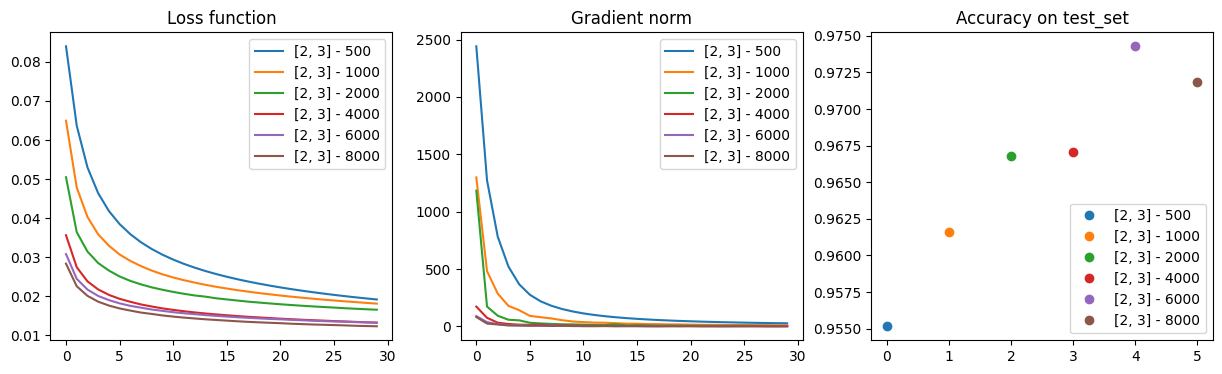

In [15]:
_, axs = plt.subplots(1, 3, figsize=(15, 4))

for i, value in enumerate(value_list):
    X_train, Y_train, X_test, Y_test = get_data_given_indeces_and_split(data, value["digits"], value["N_train"])
    w, loss_val, grads_val, err_val = SGD(loss_func, grad_func, model, np.ones(d)*1e-5, (X_train, Y_train), 512, 30)
    accuracy = np.mean([predict(w[-1], X_test, model)==Y_test])

    axs[0].plot(loss_val)
    axs[1].plot(err_val)
    axs[2].plot(i, accuracy, "o")

axs[0].set_title("Loss function")
axs[0].legend([v["legend"] for v in value_list])
axs[1].set_title("Gradient norm")
axs[1].legend([v["legend"] for v in value_list])
axs[2].set_title("Accuracy on test_set")
axs[2].legend([v["legend"] for v in value_list])

plt.show()

We can see here that with growing N_train the final loss is always lower, BUT the risk with higher train_split values it that you could overfit the set, or that the remaining few samples on the test set are not representative of the distribution

In [16]:
value_list = [
    {"digits":[2, 3], "N_train": 6000, "batch_size": 32, "legend":"[2, 3] - 6000 - SGD 32"},
    {"digits":[2, 3], "N_train": 6000, "batch_size": 128, "legend":"[2, 3] - 6000 - SGD 128"},
    {"digits":[2, 3], "N_train": 6000, "batch_size": 512, "legend":"[2, 3] - 6000 - SGD 512"},
    {"digits":[2, 3], "N_train": 6000, "batch_size": -1, "legend":"[2, 3] - 6000 - GD"},
]

100%|██████████| 100/100 [00:11<00:00,  8.63it/s]


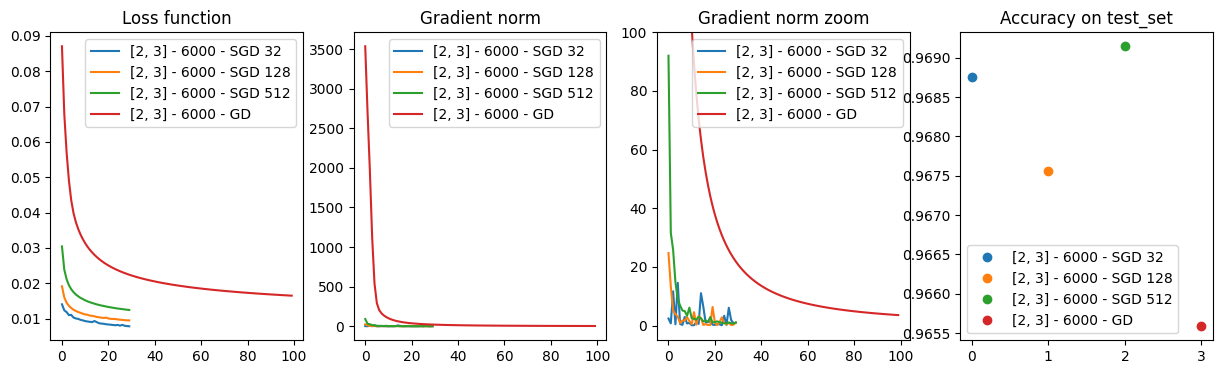

In [17]:
_, axs = plt.subplots(1, 4, figsize=(15, 4))

for i, value in enumerate(value_list):
    X_train, Y_train, X_test, Y_test = get_data_given_indeces_and_split(data, value["digits"], value["N_train"])
    w, loss_val, grads_val, err_val = SGD(loss_func, grad_func, model, np.ones(d)*1e-5, (X_train, Y_train), value["batch_size"], 30)
    accuracy = np.mean([predict(w[-1], X_test, model)==Y_test])

    axs[0].plot(loss_val)
    axs[1].plot(err_val)
    axs[2].plot(err_val)
    axs[3].plot(i, accuracy, "o")

axs[0].set_title("Loss function")
axs[0].legend([v["legend"] for v in value_list])
axs[1].set_title("Gradient norm")
axs[1].legend([v["legend"] for v in value_list])
axs[2].set_title("Gradient norm zoom")
axs[2].legend([v["legend"] for v in value_list])
axs[2].set_ylim(bottom = -5, top = 100)
axs[3].set_title("Accuracy on test_set")
axs[3].legend([v["legend"] for v in value_list])

plt.show()

We can see a pattern emerging: the smaller the batch size, the more erratic the loss function graph but also the faster the convergence. In fact, for the normal GD this is shown even more: after 100 epochs the loss is still higher than the SGD one after only 30 epochs.

This is because, during each epoch, SGD computes $N/batch_size$ updates, and even if they are not perfectly aligned with the gradient, they are mostly, helping to descend faster through the loss landscape

Moreover, we can see that even if the loss function for batch size 512 is higher than the one for 16, its accuracy on the test set is higher: this means that the fewer updates it managed were more higly informative for generalization purposes, because the gradient was more aligned with the "real" one.

GD, instead, doesn't manage the same accuracy because it simply didn't converge yet, even with more than triple the epochs of SGD

# K=3 classes

In [18]:
def get_data_given_indeces_and_split(data, indeces, N_train):
    data_copied = np.array(data)
    X = data_copied[:, 1:]
    X = X.T
    Y = data_copied[:, 0]

    d, N = X.shape
    X_hat = np.concatenate((np.ones((1,N)), X), axis=0) #for logistic

    X_hat, Y = get_data_from_index(X_hat, Y, indeces)
    _, N = X_hat.shape

    if N_train > 0.90*N:
        print("N_train too big, was brouoght to 0.90*N")
        N_train = round(0.90*N)

    (X_train, Y_train), (X_test, Y_test) = data_splits(X_hat, Y, N_train) #X_hat for logistic
    
    def one_hot_encoding(y):
        one_hot_encoded_y = np.zeros(len(indeces))
        idx = indeces.index(y)
        one_hot_encoded_y[idx]+=1
        return one_hot_encoded_y

    Y_train = np.array(list(map(one_hot_encoding, Y_train)))
    Y_test = np.array(list(map(one_hot_encoding, Y_test)))

    # Y_train = Y_train.T
    # Y_test = Y_test.T
    
    return X_train, Y_train, X_test, Y_test

In [19]:
indeces = [0, 6, 9]
N_train = 4000

X_train, Y_train, X_test, Y_test = get_data_given_indeces_and_split(data, indeces, N_train)

In [20]:
N, k = Y_test.shape

In [21]:
# we do everything for 1 sample at a time

def softmax(z):
    # z.shape = k
    # bring it closer to 0 (shifting both numerator and denominator by a constant has no effect on the result)
    # but it does effect the numerical stability because the exponential grows very fast
    z_shift = z - max(z)
    return np.exp(z_shift) / np.sum(np.exp(z_shift)) # output.shape = k

def model_softmax(w, x_hat):
    # w.shape = dxk
    # x_hat.shape = dx1 --> transposed becomes 1xd
    # the matrix multiplication is 1xk
    return softmax(x_hat.T @ w) # output.shape = 1xk

# def loss_func(w, x_hat, y, model):
#     k, N = y.shape
#     # loss is the same as for sigmoid, but now everything is a matrix (Nxk) instead of a vector
#     return np.linalg.norm(model(w, x_hat)-y)/(2*N)

def loss_func_softmax(w, x_hat, y, model):
    # y.shape = 1xk
    # loss is the same as for sigmoid, but now everything is a matrix (Nxk) instead of a vector
    return np.linalg.norm(model(w, x_hat)-y)/2 # 1xk



To find the gradient of MSE of softmax with respect to the $(d*k)$ matrix of weights $W$ you have to follow these steps:
- $D_W(\frac{1}{2} ||g(x^TW)-y||^2) = D_W(g(x^TW)) * (g(x^TW)-y)$
- $D_W(g(x^TW)) = \frac{dg(z)}{dz} * D_W(x^TW)$
- $\frac{dx^TW}{dW} = \frac{dx^TWxx^{-1}}{dW} = (\frac{dx^TWx}{dW}x^{-1} + x^TWx\frac{dx^{-1}}{dW})$ but the latter is $=0$
- so $\frac{dx^TW}{dW} = x^Txx^{-1} = x^T$
- $\frac{dg(z)}{dz} $, where g is the softmax function, is $z_i(\delta_{ij}-z_j)$, a $k*k$ matrix
- putting all together, $D_W(g(x^TW)) = z_i(\delta_{ij}-z_j) * (g(x^TW)-y) * x^T$
- Dimensionally it is $(k*k) (k*1) (1*d)$, that results in a $(k*d)$ result, same dimension as the W matrix when you transpose it

In [22]:
def grad_func_softmax(w, x_hat, y, model):
    # grad has to be sampe shape as w: dxk
    # the gradient of the softmax is a kxk matrix:
    s = model(w, x_hat) # 1xk
    softmax_grad = np.diagflat(s) - np.dot(s, s.T) # kxk

    tmp = softmax_grad @ (s-y).T
    tmp = np.expand_dims(tmp, axis=1)
    x_hat = np.expand_dims(x_hat, axis=1)

    return (tmp @ x_hat.T).T

# def predict(w, x, model, treshold=0.5):
#     results = model(w, x)
#     return np.array([1 if r>=treshold else 0 for r in results])

In [23]:
def SGD_softmax(loss_func, grad_func, model, w0, data, batch_size, n_epochs):
    '''
    Applies SGD on a logistic regressor with MSE loss
    If batch_size is set to -1, we configure it as normal GD with stopping conditions
    '''
    alpha = 1e-5
    tolx = 1e-6
    tolf = 1e-6
    
    X, Y = data

    w = [w0]
    loss_val = []
    grads_val = []
    err_val = []

    # set up for normal GD
    if batch_size == -1:
        batch_size = len(Y)
        n_epochs = 100

    k=0
    for epoch in tqdm(range(n_epochs)):
        indeces = np.arange(len(Y))
        np.random.shuffle(indeces)
        X = X[:,indeces]
        Y = Y[indeces]

        for i in range(0, len(Y), batch_size):
            batch_X = X[:,i:i+batch_size]
            batch_Y = Y[i:i+batch_size]

            gradient_update = np.zeros_like(w0)
            # take each sample in batch and get the gradients for each weight wrt the loss
            for x, y in zip(batch_X.T, batch_Y):
                gradient_update += grad_func(w[-1], x, y, model)

            new_weights = w[-1] - alpha*gradient_update/batch_size

            w.append(new_weights)
            k += 1

        loss_val.append(np.mean([loss_func(w[-1], x, y, model) for x, y in zip(X.T, Y)]))
        grads_val.append(np.mean([grad_func(w[-1], x, y, model) for x, y in zip(X.T, Y)]))
        err_val.append(np.linalg.norm(grads_val[-1])**2)

        # GD convergence check
        if batch_size == len(Y):
            if is_fininshed(grad_func, w[-1], w[-2], w[0], X, Y, model, tolf, tolx):
                break
    
    return w, loss_val, grads_val, err_val

In [24]:
w, loss_val, grads_val, err_val = SGD_softmax(loss_func_softmax, grad_func_softmax, model_softmax, np.ones((d, k))*1e-5, (X_train, Y_train), 512, 30)

100%|██████████| 30/30 [00:41<00:00,  1.40s/it]


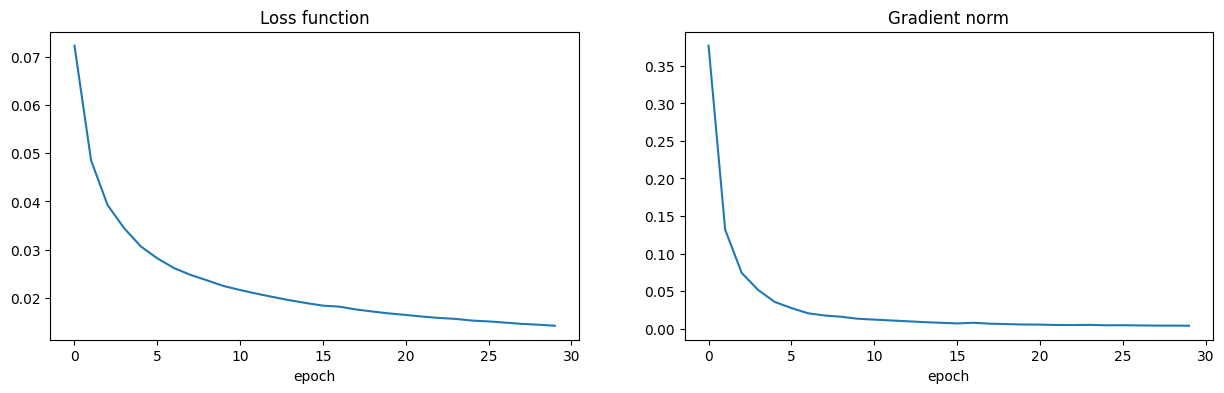

In [25]:
_, axs = plt.subplots(1, 2, figsize=(15, 4))

axs[0].plot(loss_val)
axs[0].set_title("Loss function")
axs[0].set_xlabel("epoch")

axs[1].plot(err_val)
axs[1].set_title("Gradient norm")
axs[1].set_xlabel("epoch")

plt.show()

In [26]:
def predict(w, x, model):
    results = model(w, x)
    return np.argmax(results)

predicted_labels = [predict(w[-1], x, model_softmax) for x in X_test.T]
true_labels = np.argmax(Y_test, axis=1)

accuracy = np.mean([predicted_labels == true_labels])
print("Accuracy of the logistic regression classifier: {:.2f}%".format(accuracy*100))

Accuracy of the logistic regression classifier: 98.56%


## Comparison PCA and LDA

In [27]:
def PCA(X, k):

    d, N = X.shape
    # Find the centroid of the dataset
    centroid = np.mean(X, axis=1)

    # Translate the whole dataset so that its center is in 0
    X_c = X - centroid.reshape((d, 1))

    # Compute SVD on the shifted dataset matrix
    U, S, VT = np.linalg.svd(X_c, full_matrices=False)

    # Take only the first k columns on the U matrix: this is now the projection matrix for the PCA
    U_k = U[:, :k]

    # print("Projection matrix shape: {}".format(U_k.shape))

    # Transpose the projection matrix and return it
    return U_k.T


def LDA(X, Y, k):
    d, N = X.shape
    # get unique label values
    unique_idxs = np.unique(Y)
    
    # create the clusters divided by class
    clusters = []
    for i in unique_idxs:
        cluster = X[:, (Y==i)]
        clusters.append(cluster)

    # start with constructing the WITHIN-CLUSTER scatter matrix
    # compute the centroids for each cluster
    centroids = [np.mean(cluster, axis=1) for cluster in clusters]
    # shift each cluster by their centroid so their center is in 0
    shifted_clusters = [cluster - centroid.reshape((d, 1)) 
        for cluster, centroid in zip(clusters, centroids)]
    # concatenate the shifted clusters
    Xw = np.concatenate(shifted_clusters, axis=1)
    # compute the within-cluster scatter matrix (how far is each sample from its centroid, more or less)
    Sw = Xw @ Xw.T

    # second step: construction of the BETWEEN-CLUSTER scatter matrix
    # repeat each centroid as many times as the number of samples in their cluster
    repeated_centroids = [np.repeat(centroid.reshape((d, 1)), cluster.shape[1], axis=1)
        for cluster, centroid in zip(clusters, centroids)]
    # concatenate them all
    Xbar = np.concatenate(repeated_centroids, axis=1)

    # find the global centroid of the data
    global_centroid = np.mean(X, axis=1)
    # shift the "repeated centroids matrix" by the global centroid
    Xbarc = Xbar - global_centroid.reshape((d, 1))
    # compute the between-cluster scatter matrix (how far is each centroid from the global one, more or less)
    Sb = Xbarc @ Xbarc.T

    try:
        # if the within-cluster scatter matrix is SPD, compute its cholesky decomposition
        L = np.linalg.cholesky(Sw)
    except:
        # otherwise, add a small perturbation in the form of the identity matrix
        epsilon = 1e-6
        # this shifts the eigenvalues to the right by epsilon
        # REMARK: for any matrix X, X@X^T is SPD (x^T @ A @ x >= 0), so only numerical error can make it non SPD
        # this is why epsilon is enough to bring it back to SPD
        Sw = Sw + epsilon * np.eye(Sw.shape[0])

        # once it is SPD, compute its cholesky decomposition
        L = np.linalg.cholesky(Sw)

    # Compute the first k eigenvector decomposition of L^-1 @ Sb @ L
    _, W = scipy.sparse.linalg.eigs(np.linalg.inv(L) @ Sb @ L, k=k)
    # Sb should be SPD and L^-1 @ Sb @ L is just a change of basis, so its eigenvalues should remain all POSITIVE and REAL
    # but numerical errors can add an imaginary component, so we assume that the latter is small and take only the real component
    W = np.real(W) # maybe it could be better to take the norm of each(?)
    
    # Compute Q, the projection matrix of LDA 
    Q = np.linalg.inv(L).T @ W

    # print("Projection matrix shape: {}".format(Q.shape))

    # Compute the LDA projection on the initial dataset
    return Q.T


def classify_sample(sample, centroids, classes):
    distances = [np.linalg.norm(sample-c) for c in centroids]
    return classes[np.argmin(distances)]


def get_accuracy(X_train, Y_train, X_test, Y_test):
    # get unique label values
    classes = np.unique(Y_train)
    
    centroids = []
    # create the clusters divided by class
    for i in classes:
        cluster = X_train[:, (Y_train==i)]
        centroids.append(np.mean(cluster, axis=1))

    correct_predictions = 0
    for sample, gt_class in zip(X_test.T, Y_test):
        predicted_class = classify_sample(sample, centroids, classes)
        if predicted_class == gt_class:
            correct_predictions += 1

    return correct_predictions / len(Y_test)    

In [28]:
def complete_from_data(X_train, Y_train, X_test, Y_test, k):
    # We already create the dataset splits that contain ALL the digits, then we filter them
    # otherwise, every different try will have different splits and different results
    d, _ = X_train.shape
    _, k = Y_train.shape

    w, loss_val, grads_val, err_val = SGD_softmax(loss_func_softmax, grad_func_softmax, model_softmax, np.ones((d, k))*1e-5, (X_train, Y_train), 512, 5)
    predicted_labels = [predict(w[-1], x, model_softmax) for x in X_test.T]
    true_labels = np.argmax(Y_test, axis=1)
    acc_LR = np.mean([predicted_labels == true_labels])

    X_train = X_train[1:, :]
    X_test = X_test[1:, :]
    Y_train = np.argmax(Y_train, axis=1)
    Y_test = np.argmax(Y_test, axis=1)



    projection_matrix_PCA = PCA(X_train, k)
    projection_matrix_LDA = LDA(X_train, Y_train, k)

    X_PCA_train = projection_matrix_PCA @ X_train
    X_LDA_train = projection_matrix_LDA @ X_train

    X_PCA_test = projection_matrix_PCA @ X_test
    X_LDA_test = projection_matrix_LDA @ X_test

    acc_PCA = get_accuracy(X_PCA_train, Y_train, X_PCA_test, Y_test)
    acc_LDA = get_accuracy(X_LDA_train, Y_train, X_LDA_test, Y_test)


    return acc_LR, acc_PCA, acc_LDA

In [29]:
X_train, Y_train, X_test, Y_test = get_data_given_indeces_and_split(data, indeces, N_train)
acc_LR, acc_PCA, acc_LDA = complete_from_data(X_train, Y_train, X_test, Y_test, 15)

100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


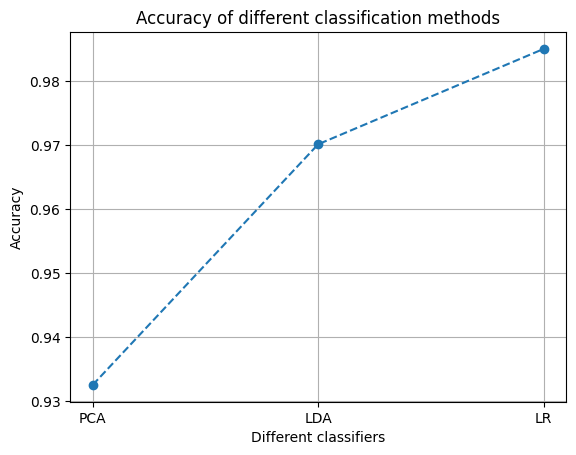

In [30]:
plt.plot(range(3), [acc_PCA, acc_LDA, acc_LR], "o--")
plt.xticks(range(3), ["PCA", "LDA", "LR"])
plt.grid(True, "major", "both")
plt.ylabel("Accuracy")
plt.xlabel("Different classifiers")
plt.title("Accuracy of different classification methods")
plt.show()